# MultiQueryAttention - MQA
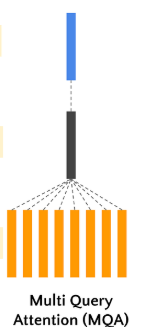

In this, multiple Query heads attend to a single shared key and value heads. 
sacrifice the ability to capture complex relationship b/w tokens



In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import math

## No KV Cache or Causal Masking

In [6]:
class MultiQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads 
        self.d_kv = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)

        # this will create the single head
        self.W_k = nn.Linear(d_model, self.d_kv, bias=False)
        self.W_v = nn.Linear(d_model, self.d_kv, bias=False)

        # output projection layer
        self.W_o = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x): 
        batch , seq, d_model = x.shape 

        Q = self.W_q(x) # query matrix
        Q = Q.view(batch, seq, self.num_heads, self.d_kv).transpose(1, 2)

        K = self.W_k(x)
        V = self.W_v(x)

        # batch, 1, seq, d_kv - single head
        K = K.unsqueeze(1)
        V = V.unsqueeze(1)

        scores = torch.matmul(Q, K.transpose(-2, -1) / math.sqrt(self.d_kv))
        attn_scores = F.softmax(scores, dim=-1)
        print(f"should be 1 if correct: {attn_scores.sum(dim=-1)}")

        attn_weights = torch.matmul(attn_scores , V)
        attn_outputs = attn_weights.transpose(1,2).contiguous() # batch, seq, head, d_kv

        attn_outputs = attn_outputs.view(batch, seq, d_model)
        out = self.W_o(attn_outputs)
        print(f"shape of out : {out.shape}")

        return out




In [7]:
batch = 2 
seq =  10
d_model = 64 
num_heads = 8 

x = torch.randn(batch, seq, d_model)
print(f"x.shape : {x.shape}")

mqa = MultiQueryAttention(d_model, num_heads)
out = mqa(x)

x.shape : torch.Size([2, 10, 64])
should be 1 if correct: tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.000

## With KV_Cache
kv_cache stores previous Key and Value and only compute for current token. 

In [12]:
class MultiQueryAttention_V2(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads 
        self.d_kv = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)

        # this will create the single head
        self.W_k = nn.Linear(d_model, self.d_kv, bias=False)
        self.W_v = nn.Linear(d_model, self.d_kv, bias=False)

        # output projection layer
        self.W_o = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x, kv_cache=None, use_kv_cache=False): 
        batch , seq, d_model = x.shape 

        Q = self.W_q(x) # query matrix
        Q = Q.view(batch, seq, self.num_heads, self.d_kv).transpose(1, 2)

        K = self.W_k(x)
        V = self.W_v(x)

        # batch, 1, seq, d_kv - single head
        K = K.unsqueeze(1)
        V = V.unsqueeze(1)

        if kv_cache is not None:
            K = torch.concat([kv_cache["k"], K], dim=2)
            V = torch.concat([kv_cache["v"], V], dim=2)
        
        if use_kv_cache:
            new_kv_cache = {
                "k" : K.detach(), 
                "v" : V.detach()
            }
        else: 
            new_kv_cache = None

        print(f"Q shape : {Q.shape}\nK.shape: {K.shape}\nV.shape: {V.shape}")

        scores = torch.matmul(Q, K.transpose(-2, -1) / math.sqrt(self.d_kv))
        attn_scores = F.softmax(scores, dim=-1)
        # print(f"should be 1 if correct: {attn_scores.sum(dim=-1)}")

        attn_weights = torch.matmul(attn_scores , V)
        attn_outputs = attn_weights.transpose(1,2).contiguous() # batch, seq, head, d_kv

        attn_outputs = attn_outputs.view(batch, seq, d_model)
        out = self.W_o(attn_outputs)
        print(f"shape of out : {out.shape}")

        return out, new_kv_cache




In [16]:
batch = 2 
seq =  10
d_model = 64 
num_heads = 8 

x = torch.randn(batch, seq, d_model)
print(f"x.shape : {x.shape}")

mqa_kv = MultiQueryAttention_V2(d_model, num_heads)
kv_cache = None 

# not ideal , correct implemntation
# out , _ = mqa_kv(x)

for i in range(seq):
    print(f"\n--------------------")
    x_token = x[:, i:i+1, :] # batch , 1 , d_model
    output, kv_cache = mqa_kv(x_token, kv_cache=kv_cache, use_kv_cache=True)

x.shape : torch.Size([2, 10, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 1, 8])
V.shape: torch.Size([2, 1, 1, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 2, 8])
V.shape: torch.Size([2, 1, 2, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 3, 8])
V.shape: torch.Size([2, 1, 3, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 4, 8])
V.shape: torch.Size([2, 1, 4, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 5, 8])
V.shape: torch.Size([2, 1, 5, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 6, 8])
V.shape: torch.Size([2, 1, 6, 8])
shape of out : torch.Size(

## with KV Cache and Causal Masking

Demonstrating masking

In [24]:
x = torch.randn(5,5)
print(x)

mask = torch.triu(torch.ones(5,5, dtype=torch.bool), diagonal=1)
print(f"\n{mask}")

masked_x = x.masked_fill(mask, float("-inf"))
print(f"\n{masked_x}")


tensor([[ 0.1464, -0.6353, -0.4628, -0.7955, -0.0307],
        [ 2.5423, -0.6772,  0.7265,  2.2504,  0.6527],
        [ 1.1242,  0.2020,  0.9589, -0.2554,  2.1855],
        [-0.5736, -0.8683,  0.1676, -0.0050,  0.2687],
        [ 1.3856, -0.2750,  1.6399,  0.0066, -0.2922]])

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

tensor([[ 0.1464,    -inf,    -inf,    -inf,    -inf],
        [ 2.5423, -0.6772,    -inf,    -inf,    -inf],
        [ 1.1242,  0.2020,  0.9589,    -inf,    -inf],
        [-0.5736, -0.8683,  0.1676, -0.0050,    -inf],
        [ 1.3856, -0.2750,  1.6399,  0.0066, -0.2922]])


In [29]:
class MultiQueryAttention_V3(nn.Module):
    """
    with both KV_Cache and cauasl masking in attention
    """
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads 
        self.d_kv = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)

        # this will create the single head
        self.W_k = nn.Linear(d_model, self.d_kv, bias=False)
        self.W_v = nn.Linear(d_model, self.d_kv, bias=False)

        # output projection layer
        self.W_o = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x, kv_cache=None, use_kv_cache=False): 
        batch , seq, d_model = x.shape 

        Q = self.W_q(x) # query matrix
        Q = Q.view(batch, seq, self.num_heads, self.d_kv).transpose(1, 2)

        K = self.W_k(x)
        V = self.W_v(x)

        # batch, 1, seq, d_kv - single head
        K = K.unsqueeze(1)
        V = V.unsqueeze(1)
        
        past_len = 0
        if kv_cache is not None:
            past_len = kv_cache["k"].shape[2] # seq
            K = torch.concat([kv_cache["k"], K], dim=2)
            V = torch.concat([kv_cache["v"], V], dim=2)
        
        if use_kv_cache:
            new_kv_cache = {
                "k" : K.detach(), 
                "v" : V.detach()
            }
        else: 
            new_kv_cache = None

        print(f"Q shape : {Q.shape}\nK.shape: {K.shape}\nV.shape: {V.shape}")

        scores = torch.matmul(Q, K.transpose(-2, -1) / math.sqrt(self.d_kv))
        if seq > 1: # otherwise causal masking wont work
            total_len = past_len + seq 
            scores = scores.masked_fill(torch.triu(torch.ones(seq, total_len, dtype=torch.bool, device=scores.device), diagonal=past_len+1), float("-inf"))
                        
        attn_scores = F.softmax(scores, dim=-1)
        # print(f"should be 1 if correct: {attn_scores.sum(dim=-1)}")

        attn_weights = torch.matmul(attn_scores , V)
        attn_outputs = attn_weights.transpose(1,2).contiguous() # batch, seq, head, d_kv

        attn_outputs = attn_outputs.view(batch, seq, d_model)
        out = self.W_o(attn_outputs)
        print(f"shape of out : {out.shape}")

        return out, new_kv_cache




In [30]:
batch = 2 
seq =  10
d_model = 64 
num_heads = 8 

x = torch.randn(batch, seq, d_model)
print(f"x.shape : {x.shape}")

mqa_kv = MultiQueryAttention_V3(d_model, num_heads)
kv_cache = None 

# not ideal , correct implemntation
# out , _ = mqa_kv(x)

for i in range(seq):
    print(f"\n--------------------")
    x_token = x[:, i:i+1, :] # batch , 1 , d_model
    output, kv_cache = mqa_kv(x_token, kv_cache=kv_cache, use_kv_cache=True)

x.shape : torch.Size([2, 10, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 1, 8])
V.shape: torch.Size([2, 1, 1, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 2, 8])
V.shape: torch.Size([2, 1, 2, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 3, 8])
V.shape: torch.Size([2, 1, 3, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 4, 8])
V.shape: torch.Size([2, 1, 4, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 5, 8])
V.shape: torch.Size([2, 1, 5, 8])
shape of out : torch.Size([2, 1, 64])

--------------------
Q shape : torch.Size([2, 8, 1, 8])
K.shape: torch.Size([2, 1, 6, 8])
V.shape: torch.Size([2, 1, 6, 8])
shape of out : torch.Size(

Thus, have implemented Multi Query Attention. 